In [24]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from config import *

# use keras tokenizer instead
import keras
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer 
import json

# building a NN model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import metrics

# building a sentiment NN
from keras.preprocessing import sequence
from keras.layers import Embedding, LSTM, Dense, Dropout

# import extra metrics
import keras_metrics 
#(https://stackoverflow.com/questions/
# 43076609/how-to-calculate-precision-and-recall-in-keras)

# Heavily inspired by the following tutorials
- https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
- https://www.kaggle.com/lalitparihar44/detailed-text-based-feature-engineering
- https://machinelearnings.co/text-classification-using-neural-networks-f5cd7b8765c6
- https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
- https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
- https://vgpena.github.io/classifying-tweets-with-keras-and-tensorflow/

Many of the techniques I used in Keras, I "learned" via these online tutorials and then applied to my own work. Many of the thought processes are quite similar to those in these tutorials -- I picked and chose what would work for me, and then I adapted as necessary. 

## explore training data

In [2]:
train_df = pd.read_csv(TRAIN)

In [3]:
### only training data now
tweet_corpus = train_df.iloc[:, 0]
tweet_sentiment = train_df.iloc[:, 1]

# note that I do this in both files. I wanted to keep 
# my categories flexible from file to file, and this is 
# the execution of a single switch. I didn't think I 
# absolutely needed to refactor here. 
tweet_sentiment_coded = pd.Series(np.where(
    tweet_sentiment == 'About the police - Positive', 1, 
        np.where(tweet_sentiment == 'About the police - Negative', 2, 
            np.where(tweet_sentiment == 'About the police - Neutral', 3, 
                np.where(tweet_sentiment == 'Not about the police', 0, "Error")))))

In [4]:
tweet_sentiment.value_counts()

About the police - Neutral     256
Not about the police           236
About the police - Positive    142
About the police - Negative    134
Name: Answer.sentiment.label, dtype: int64

## create a dictionary file

This was inspired by: https://vgpena.github.io/classifying-tweets-with-keras-and-tensorflow/

In [5]:
# only work with the most popular words found in our dataset
MAX_WORDS = 3000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(tweet_corpus)

dictionary = tokenizer.word_index
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

## build a basic neural net using Keras

In [6]:
def convert_text_to_index_array(text):
    """
    Makes all text the same length
    """
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

indices = []

# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in tweet_corpus:
    word_indices = [dictionary[word] for word in kpt.text_to_word_sequence(text)]
    indices.append(word_indices)

# cast as an array for future usage.
indices = np.asarray(indices)

# create one-hot matrices out of the indexed tweets
train_x = tokenizer.sequences_to_matrix(indices, mode='binary')
# treat the labels as categories
train_y = keras.utils.to_categorical(tweet_sentiment_coded)

In [7]:
# here, I construct the model layers for this project. 
# regardless of the number of layer, dropout rate, activation
# function, this neural net performs terribly, but you 
# can see the summary for this example below. I also tried with 
# three layers only. 
model = Sequential()
model.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
model.add(Dropout(0.25))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(150, activation='softmax'))
model.add(Dropout(0.25))

model.add(Dense(100, activation='softmax'))
model.add(Dropout(0.25))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.categorical_accuracy])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)  

## train the model

The statistic on the validation set here suggests just how terrible this model truly was. I did not pursue this further. 

In [8]:
model.fit(train_x, train_y,
  batch_size=64,
  epochs=25,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 2s 4ms/step - loss: 1.3861 - mean_absolute_error: 0.3750 - categorical_accuracy: 0.2812 - val_loss: 1.3834 - val_mean_absolute_error: 0.3746 - val_categorical_accuracy: 0.3203
Epoch 2/25
537/537 [==============================] - 0s 277us/step - loss: 1.3826 - mean_absolute_error: 0.3745 - categorical_accuracy: 0.3017 - val_loss: 1.3787 - val_mean_absolute_error: 0.3740 - val_categorical_accuracy: 0.3203
Epoch 3/25
537/537 [==============================] - 0s 283us/step - loss: 1.3797 - mean_absolute_error: 0.3741 - categorical_accuracy: 0.3184 - val_loss: 1.3749 - val_mean_absolute_error: 0.3735 - val_categorical_accuracy: 0.3203
Epoch 4/25
537/537 [==============================] - 0s 275us/step - loss: 1.3774 - mean_absolute_error: 0.3738 - categorical_accuracy: 0.2998 - val_loss: 1.3712 - val_mean_absolute_error: 0.3730 - val_categoric

## showing other options

Here I construct two additional models -- one with no drop out and one with fewer layers -- to demonstrate that the dearth of data is ruining the model. It is not behaving as we would expect it to. 

In [9]:
no_drop_out = Sequential()
no_drop_out.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
no_drop_out.add(Dense(100, activation='relu'))
no_drop_out.add(Dense(100, activation='sigmoid'))
no_drop_out.add(Dense(4, activation='softmax'))

no_drop_out.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.categorical_accuracy])
print(no_drop_out.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               300100    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 404       
Total params: 320,704
Trainable params: 320,704
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
no_drop_out.fit(train_x, train_y,
  batch_size=64,
  epochs=25,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 1s 3ms/step - loss: 1.4465 - mean_absolute_error: 0.3772 - categorical_accuracy: 0.2458 - val_loss: 1.3688 - val_mean_absolute_error: 0.3707 - val_categorical_accuracy: 0.3203
Epoch 2/25
537/537 [==============================] - 0s 189us/step - loss: 1.3570 - mean_absolute_error: 0.3680 - categorical_accuracy: 0.3166 - val_loss: 1.3268 - val_mean_absolute_error: 0.3620 - val_categorical_accuracy: 0.3506
Epoch 3/25
537/537 [==============================] - 0s 185us/step - loss: 1.3578 - mean_absolute_error: 0.3640 - categorical_accuracy: 0.3259 - val_loss: 1.3296 - val_mean_absolute_error: 0.3600 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 0s 167us/step - loss: 1.3594 - mean_absolute_error: 0.3641 - categorical_accuracy: 0.3259 - val_loss: 1.3304 - val_mean_absolute_error: 0.3621 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [========

Fewer layers is definitely *better* by a little -- it has about 50% accuracy -- but still less than ideal.

In [11]:
few_layers = Sequential()
few_layers.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
few_layers.add(Dropout(0.25))

few_layers.add(Dense(100, activation='relu'))
few_layers.add(Dropout(0.25))

few_layers.add(Dense(4, activation='softmax'))

few_layers.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.categorical_accuracy])
print(few_layers.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               300100    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 404       
Total params: 310,604
Trainable params: 310,604
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
few_layers.fit(train_x, train_y,
  batch_size=64,
  epochs=25,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 2s 3ms/step - loss: 1.3816 - mean_absolute_error: 0.3744 - categorical_accuracy: 0.3017 - val_loss: 1.3724 - val_mean_absolute_error: 0.3731 - val_categorical_accuracy: 0.3203
Epoch 2/25
537/537 [==============================] - 0s 207us/step - loss: 1.3714 - mean_absolute_error: 0.3729 - categorical_accuracy: 0.3408 - val_loss: 1.3602 - val_mean_absolute_error: 0.3713 - val_categorical_accuracy: 0.4848
Epoch 3/25
537/537 [==============================] - 0s 186us/step - loss: 1.3661 - mean_absolute_error: 0.3718 - categorical_accuracy: 0.3128 - val_loss: 1.3500 - val_mean_absolute_error: 0.3695 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 0s 184us/step - loss: 1.3573 - mean_absolute_error: 0.3701 - categorical_accuracy: 0.3352 - val_loss: 1.3418 - val_mean_absolute_error: 0.3678 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [========

As one last hail mary, I wanted to see if I simply detected negative sentiment, if this model would work... 

This ends up being somewhat good, but not better than traditional models or baseline, and a lot more opaque. The precision is way better, though. 

In [34]:
simple_few_layers = Sequential()
simple_few_layers.add(Dense(100, input_shape=(MAX_WORDS,), activation='softmax'))
simple_few_layers.add(Dropout(0.25))
simple_few_layers.add(Dense(100, activation='relu'))
simple_few_layers.add(Dropout(0.25))
simple_few_layers.add(Dense(2, activation='softmax'))
simple_few_layers.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, keras_metrics.precision(), metrics.categorical_accuracy])
print(simple_few_layers.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 100)               300100    
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 202       
Total params: 310,402
Trainable params: 310,402
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
simple_tweet_sentiment_coded = pd.Series(
    np.where(tweet_sentiment == 'About the police - Negative', 1, 0))
simple_train_y = keras.utils.to_categorical(simple_tweet_sentiment_coded)

In [38]:
train_history = simple_few_layers.fit(train_x, simple_train_y,
  batch_size=64,
  epochs=25,
  verbose=1,
  validation_split=0.3,
  shuffle=True)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 0s 224us/step - loss: 0.2097 - mean_absolute_error: 0.1581 - precision: 0.9119 - categorical_accuracy: 0.9143 - val_loss: 0.4262 - val_mean_absolute_error: 0.2473 - val_precision: 0.8489 - val_categorical_accuracy: 0.8355
Epoch 2/25
537/537 [==============================] - 0s 208us/step - loss: 0.1939 - mean_absolute_error: 0.1444 - precision: 0.9332 - categorical_accuracy: 0.9311 - val_loss: 0.4304 - val_mean_absolute_error: 0.2413 - val_precision: 0.8482 - val_categorical_accuracy: 0.8312
Epoch 3/25
537/537 [==============================] - 0s 197us/step - loss: 0.1796 - mean_absolute_error: 0.1334 - precision: 0.9393 - categorical_accuracy: 0.9367 - val_loss: 0.4354 - val_mean_absolute_error: 0.2378 - val_precision: 0.8520 - val_categorical_accuracy: 0.8355
Epoch 4/25
537/537 [==============================] - 0s 195us/step - loss: 0.1590 - mean_absolute_error: 0.1205 - precision: 

# plotting some results
https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

In [ ]:
def plot_keras_metrics(train_history):
    """
    Utility code for plots
    Input train_history, a keras object
    Returns nothing, generates plot
    """
    plt.plot(train_history.history['val_precision'])
    plt.plot(train_history.history['precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(train_history.history['val_categorical_accuracy'])
    plt.plot(train_history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

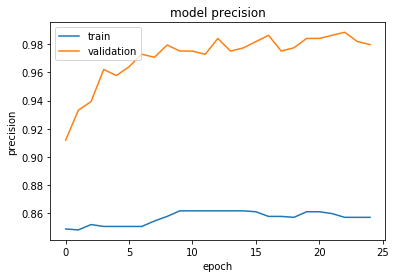

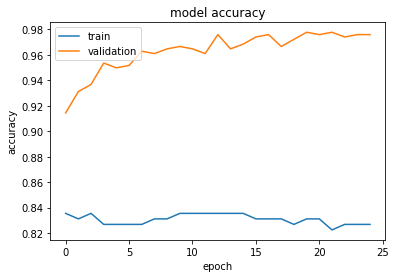

In [40]:
plot_keras_metrics(train_history)

# building a sentiment RNN

Tutorial source:
https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

In [44]:
MAX_LEN_TWEET = 30
EMBEDDING_SIZE = 5
BATCH_SIZE = 64
EPOCHS_NUMBER = 25

In [45]:
# padding sequences to get uniform length, similar to above
train_x_rnn = sequence.pad_sequences(train_x, maxlen=MAX_LEN_TWEET)

## construct the model
As before, this is just one example of the many examples that failed :) I tried more types -- more layers, less layers, different activations -- but this seemed like a good representative model to demonstrate that this... didn't really work

In [46]:
rnn = Sequential()
rnn.add(Embedding(MAX_LEN_TWEET, EMBEDDING_SIZE, input_length=MAX_LEN_TWEET))
rnn.add(Dropout(0.25))
rnn.add(LSTM(100))
rnn.add(Dropout(0.25))
rnn.add(Dense(4, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=[metrics.mae, metrics.categorical_accuracy])

print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 5)             150       
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 5)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 404       
Total params: 42,954
Trainable params: 42,954
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
rnn.fit(
    train_x_rnn, train_y, 
    validation_split=0.3, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS_NUMBER)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 5s 9ms/step - loss: 1.3831 - mean_absolute_error: 0.4994 - categorical_accuracy: 0.3222 - val_loss: 1.3739 - val_mean_absolute_error: 0.4986 - val_categorical_accuracy: 0.3506
Epoch 2/25
537/537 [==============================] - 1s 1ms/step - loss: 1.3695 - mean_absolute_error: 0.4995 - categorical_accuracy: 0.3259 - val_loss: 1.3329 - val_mean_absolute_error: 0.4917 - val_categorical_accuracy: 0.3506
Epoch 3/25
537/537 [==============================] - 1s 2ms/step - loss: 1.3568 - mean_absolute_error: 0.4965 - categorical_accuracy: 0.3259 - val_loss: 1.3327 - val_mean_absolute_error: 0.4918 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 1s 2ms/step - loss: 1.3547 - mean_absolute_error: 0.4974 - categorical_accuracy: 0.3277 - val_loss: 1.3321 - val_mean_absolute_error: 0.4918 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [==============

## additional models

As above, I wanted to show a few samples of other things that didn't work :)

In [48]:
no_dropout = Sequential()
no_dropout.add(Embedding(MAX_LEN_TWEET, EMBEDDING_SIZE, input_length=MAX_LEN_TWEET))
no_dropout.add(LSTM(100))
no_dropout.add(Dense(4, activation='sigmoid'))
no_dropout.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=[metrics.mae, metrics.categorical_accuracy])

no_dropout.fit(
    train_x_rnn, train_y, 
    validation_split=0.3, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS_NUMBER)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 5s 9ms/step - loss: 1.3825 - mean_absolute_error: 0.4987 - categorical_accuracy: 0.3166 - val_loss: 1.3710 - val_mean_absolute_error: 0.4954 - val_categorical_accuracy: 0.3506
Epoch 2/25
537/537 [==============================] - 1s 1ms/step - loss: 1.3641 - mean_absolute_error: 0.4894 - categorical_accuracy: 0.3073 - val_loss: 1.3284 - val_mean_absolute_error: 0.4647 - val_categorical_accuracy: 0.3203
Epoch 3/25
537/537 [==============================] - 1s 2ms/step - loss: 1.3553 - mean_absolute_error: 0.4812 - categorical_accuracy: 0.3128 - val_loss: 1.3417 - val_mean_absolute_error: 0.4838 - val_categorical_accuracy: 0.3506
Epoch 4/25
537/537 [==============================] - 1s 1ms/step - loss: 1.3570 - mean_absolute_error: 0.4880 - categorical_accuracy: 0.3259 - val_loss: 1.3384 - val_mean_absolute_error: 0.4827 - val_categorical_accuracy: 0.3506
Epoch 5/25
537/537 [==============

## rnn negative sentiment only

In [51]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(MAX_LEN_TWEET, EMBEDDING_SIZE, input_length=MAX_LEN_TWEET))
simple_rnn.add(Dropout(0.25))
simple_rnn.add(LSTM(100))
simple_rnn.add(Dropout(0.25))
simple_rnn.add(Dense(2, activation='sigmoid'))
simple_rnn.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=[metrics.mae, keras_metrics.precision(), metrics.categorical_accuracy])

print(simple_rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 5)             150       
_________________________________________________________________
dropout_26 (Dropout)         (None, 30, 5)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               42400     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
Total params: 42,752
Trainable params: 42,752
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
train_history_rnn = simple_rnn.fit(
    train_x_rnn, simple_train_y, 
    validation_split=0.3, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS_NUMBER, 
    shuffle=True,
    verbose=1)

Train on 537 samples, validate on 231 samples
Epoch 1/25
537/537 [==============================] - 1s 1ms/step - loss: 0.4787 - mean_absolute_error: 0.2726 - precision: 0.8175 - categorical_accuracy: 0.8175 - val_loss: 0.4358 - val_mean_absolute_error: 0.2609 - val_precision: 0.8442 - val_categorical_accuracy: 0.8442
Epoch 2/25
537/537 [==============================] - 1s 2ms/step - loss: 0.4749 - mean_absolute_error: 0.2850 - precision: 0.8175 - categorical_accuracy: 0.8175 - val_loss: 0.4386 - val_mean_absolute_error: 0.2680 - val_precision: 0.8442 - val_categorical_accuracy: 0.8442
Epoch 3/25
537/537 [==============================] - 1s 1ms/step - loss: 0.4838 - mean_absolute_error: 0.2764 - precision: 0.8175 - categorical_accuracy: 0.8175 - val_loss: 0.4336 - val_mean_absolute_error: 0.2486 - val_precision: 0.8442 - val_categorical_accuracy: 0.8442
Epoch 4/25
537/537 [==============================] - 1s 2ms/step - loss: 0.4772 - mean_absolute_error: 0.2772 - precision: 0.8175 -

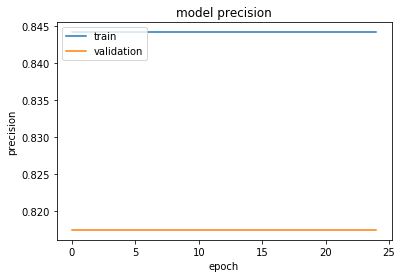

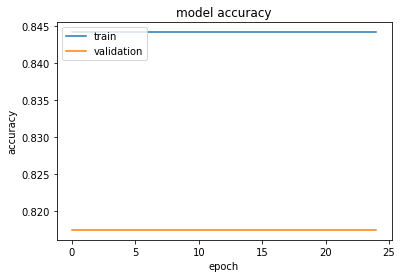

In [58]:
plot_keras_metrics(train_history_rnn)